In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
import scipy.ndimage

In [8]:
ls

MA2_0145.JPG*  MA2_0148.JPG*  MA2_0151.JPG*  MA2_0154.JPG*  MA2_0157.JPG*
MA2_0146.JPG*  MA2_0149.JPG*  MA2_0152.JPG*  MA2_0155.JPG*
MA2_0147.JPG*  MA2_0150.JPG*  MA2_0153.JPG*  MA2_0156.JPG*


In [9]:
cd worm13

[Errno 2] No such file or directory: 'worm13'
/home/tushara/Documents/projects/phylab/elegans/worm13/worm13


In [10]:
ls

MA2_0145.JPG*  MA2_0148.JPG*  MA2_0151.JPG*  MA2_0154.JPG*  MA2_0157.JPG*
MA2_0146.JPG*  MA2_0149.JPG*  MA2_0152.JPG*  MA2_0155.JPG*
MA2_0147.JPG*  MA2_0150.JPG*  MA2_0153.JPG*  MA2_0156.JPG*


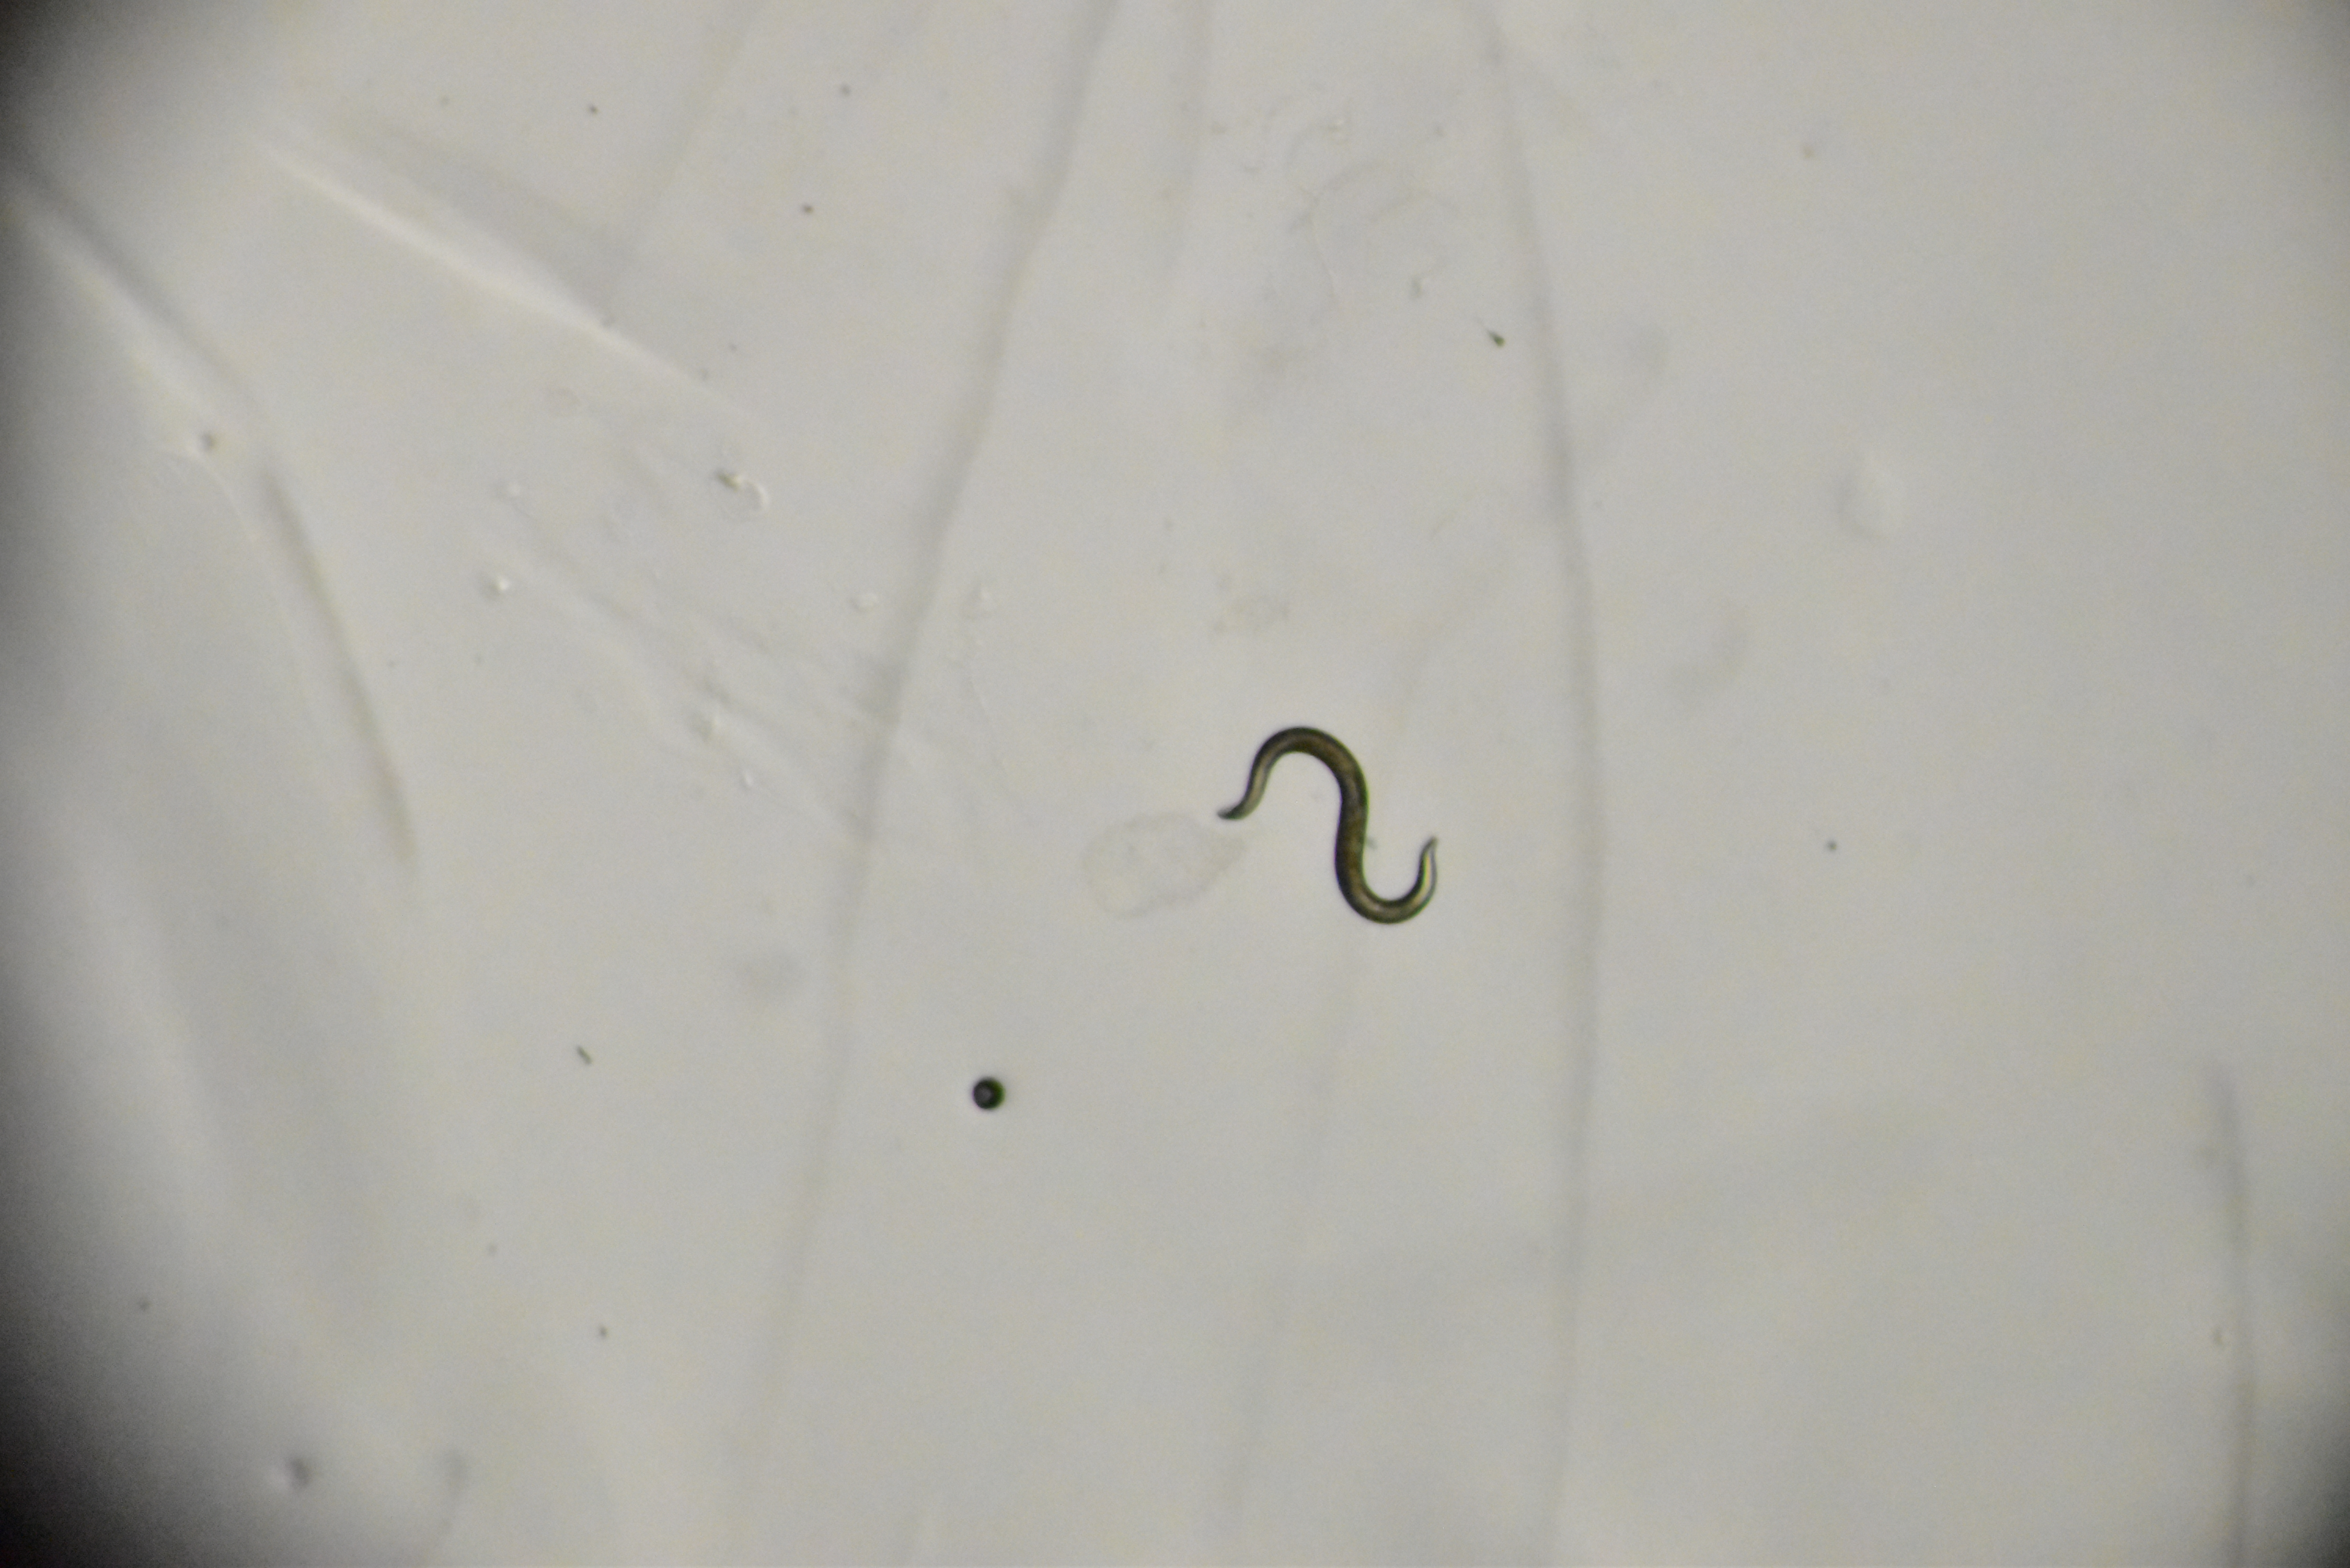

In [11]:
Image(filename="./MA2_0145.JPG", height = 500, width = 500)

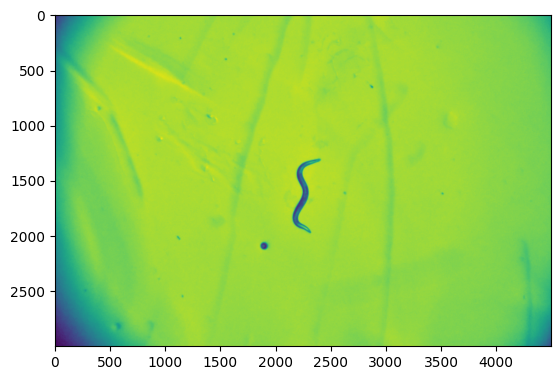

In [12]:
img = cv2.imread("MA2_0157.JPG", 0)
plt.imshow(img)
plt.show()

## Cropping the image to focus on the object

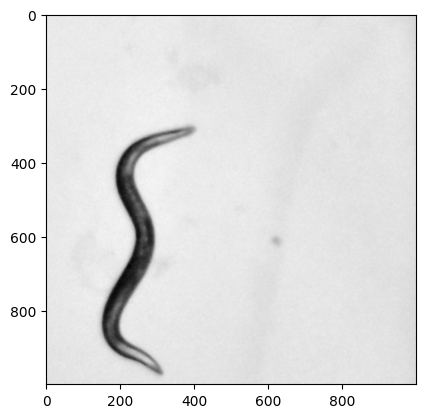

In [13]:
img_crop = img[1000:2000, 2000:3000] # here, i think the image scale has become 1000x1000
plt.imshow(img_crop, cmap = "gray")
plt.show()

## Defining a binary image of the object

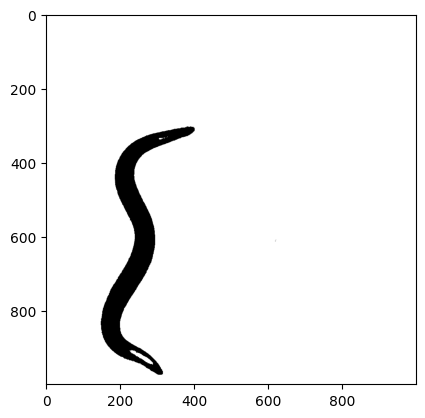

In [14]:
ret, img_thres = (cv2.threshold(img_crop, 150, 255, cv2.THRESH_BINARY)) # reference: 255 = white; 0 = black; so here if p>thres -> 255; elif p<=thres -> 0; using cv2.THRESH_BINARY_INV would inverse it such that the foreground is white and background is black
plt.imshow(img_thres, cmap = "gray")
plt.show()

## Filling the holes in the binary image of the object

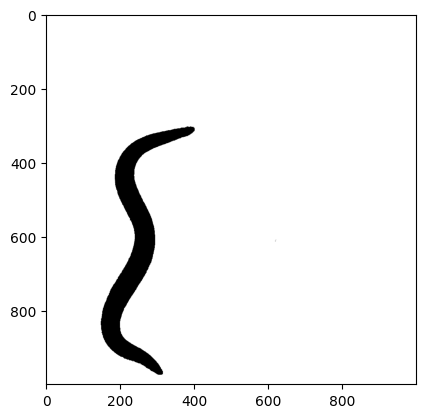

In [15]:
# since my image's foreground is black, scipy.ndimage.binary_fill_holes assumes foreground to be white, so 

# here, True = Black and False = White. the scipy function converts all False to True. Using ~ (bitwise NOT) flips this True-False. Or, I could use cv2.bitwise_not
# note: cv2.bitwse_not works on integer arrays; using scipy function returns a boolean array, on which I cannot use the bitwise_not function anymore, so i have to use np.uint8 to convert the boolean to integer array
'''img_fill = cv2.bitwise_not(np.uint8(scipy.ndimage.binary_fill_holes(cv2.bitwise_not(img_thres)))*255)
plt.imshow(img_fill, cmap = "gray")'''

# simpler version using ~ operator:
img_fill = np.uint8(~scipy.ndimage.binary_fill_holes(~img_thres))*255
plt.imshow(img_fill, cmap = "gray")

## Defining the contour of the filled binary image of the object

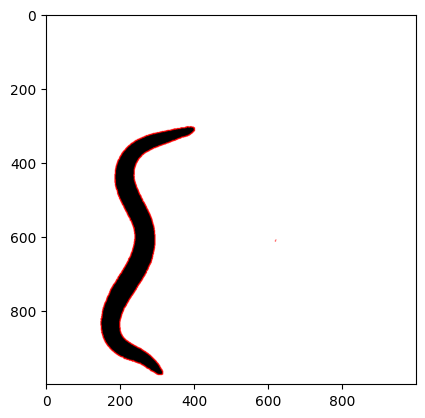

In [16]:
contours, hierarchy = cv2.findContours(cv2.bitwise_not(img_fill), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) # here i had to inverse the image using bitwise_not because this function treats zero pixels as background. here the worm is zero pixel, so i had to make it white (non-zero pixel) so that it is treated as foreground
img_cont = cv2.cvtColor(img_fill, cv2.COLOR_GRAY2BGR) # to apply the contour color, i needed to convert from single channel to multi channel
cv2.drawContours(img_cont, contours, -1, (255,0,0), 2)
plt.imshow(img_cont, cmap = "gray")
plt.show()

## Finding and mapping the center of mass of the object

In [17]:
# I could also have used first order moments to find the centroid:
M = cv2.moments(255 - img_fill) # realized that the cv2.moments treats the white pixels as the foreground!!!
x_b = int(M["m10"] /M["m00"]) # first order_x by zeroth order
y_b = int(M["m01"] /M["m00"]) # first order_y by zeroth order

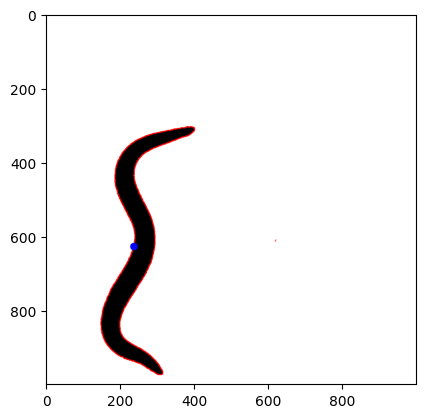

In [18]:
img_cent = cv2.circle(img_cont, (x_b, y_b), 10, (0,0,255), -1) # note that i did GRAY2RGB but opencv takes BGR, so (0,0,255) gave blue instead of red; so instead of converting to BGR and RGB, ijust did (255,0,0).
plt.imshow(img_cent)
plt.show()

## Finding the contour length of the object

In [19]:
# Contour Length of the Worm

# print(contours) gives a list with each element as an array representing a contour. for the image 0157, i get three elements, and contours[3] has the largest size (926 points). using max(, key = area) allows me to restrict measurement within contour with largest area and ignore the other noise.
cnt = max(contours, key = cv2.contourArea)

'''print(np.squeeze(contours[0])) # shape = (801, 2)
print(contours[0].shape[0]) # this is the number of points in the boundary of the worm that are joined to form the contour)
print(cv2.arcLength(cont, True)/contours[0].shape[0]) # distance between two contour points'''

p = cv2.arcLength(cnt, True) # length of the entire contour -- the perimeter of the object
a = cv2.contourArea(cnt)

print("perimeter:", p)
print("area:", a)

# assuming the worm to be shaped like a capsule with rectangle of length l and two side hemispheres of radius r then
# p = 2l + 2*pi*r and a = pr - pi*r^2
# since i am only considering the whole perimeter and area, and assuming small hemispheres on the side such that they don't curve, then this holds despite curves in the "rectangle."

if (p + (p**(2) - 4*a*np.pi)**(1/2))/(2*np.pi) > (p - (p**(2) - 4*a*np.pi)**(1/2))/(2*np.pi):
    r = (p - (p**(2) - 4*a*np.pi)**(1/2))/(2*np.pi)
else: 
    r = (p + (p**(2) - 4*a*np.pi)**(1/2))/(2*np.pi)

l = (p - 2*np.pi*r)/2

w_l = l + 2*r
print("worm length:", w_l)

perimeter: 1935.8073406219482
area: 40585.0
worm length: 943.0947401115801


## Finding the orientation of the object

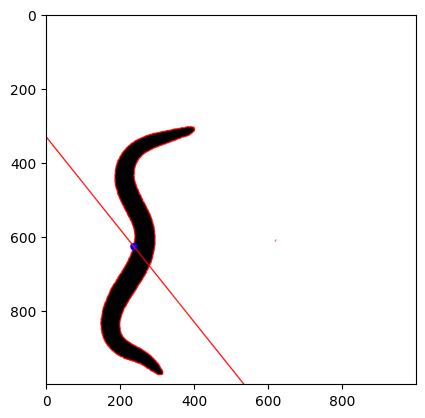

In [20]:
a = cv2.moments(img_fill)["mu20"]
b = cv2.moments(img_fill)["mu11"]
c = cv2.moments(img_fill)["mu02"]

ang = 0.5* np.arctan2(2*b, (a-c))
x_o = np.linspace(x_b-1000, x_b + 1000, 200)
y_o = (x_o - x_b)*np.tan(ang) + y_b

img_ornt = cv2.line(img_cent, (int(x_o[0]), int(y_o[0])),(int(x_o[-1]),int(y_o[-1])), (255,0,0), 2)
plt.imshow(img_ornt)
plt.show()

# do i have to redefine x_o i think?

In [21]:
y, x = np.where(img_fill == 0)
print(x, y)
print(x[0],y[0])

[380 381 382 ... 310 311 312] [304 304 304 ... 974 974 974]
380 304


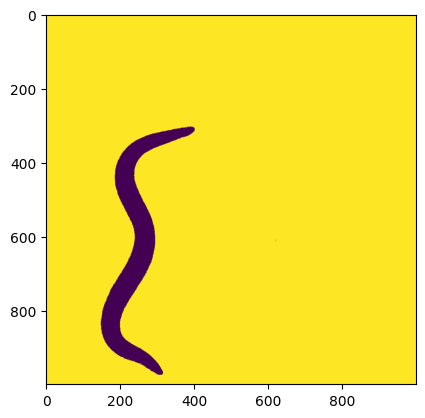

In [22]:
img_test = cv2.circle(img_fill, (x[0],y[0]), 2, (255,0,255), -1) # note that i did GRAY2RGB but opencv takes BGR, so (0,0,255) gave blue instead of red; so instead of converting to BGR and RGB, ijust did (255,0,0).
plt.imshow(img_test)
plt.show()